#### Installing required packages

In [1]:
!pip install wfdb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 2.5 MB/s eta 0:00:00


In [2]:
!pip install neurokit2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.1/693.1 kB 12.3 MB/s eta 0:00:00


In [3]:
!pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 30.6 MB/s eta 0:00:00


#### Importing required libraries

In [35]:
import os
import wfdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pywt
from scipy.signal import butter, filtfilt
from scipy.signal import find_peaks
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from scipy.ndimage import gaussian_filter1d

#### Analysis on single data sample

In [6]:
# Data directory path where dataset is stored
data_dir = '/content/drive/MyDrive/stress-recognition-in-automobile-drivers-1.0.0'
# Considering one record for analysis
record_name = 'drive01'
# Loading the record
record = wfdb.rdsamp(os.path.join(data_dir, record_name))
signal, fields = record[0], record[1]
#'signal' contains ECG data and 'fields' contains metadata
print(signal)
print(fields)

[[-3.0000e-02 -7.2000e-03  2.5040e+00  1.1146e+01  8.4000e+01  1.0948e+01]
 [-2.6000e-02 -3.3000e-03  2.5120e+00  1.1136e+01  8.4000e+01  1.0958e+01]
 [-1.6000e-02  1.9000e-03  2.5140e+00  1.1127e+01  8.4000e+01  1.0982e+01]
 ...
 [ 6.7000e-02 -4.9000e-03  1.7850e+00  2.3291e+01  9.4000e+01  1.1642e+01]
 [ 5.4000e-02  1.5000e-03  1.7850e+00  2.3502e+01  9.4000e+01  1.1750e+01]
 [ 4.9000e-02 -6.4000e-03  1.7860e+00  2.3738e+01  9.4000e+01  1.1828e+01]]
{'fs': 15.5, 'sig_len': 61499, 'n_sig': 6, 'base_date': None, 'base_time': None, 'units': ['mV', 'mV', 'mV', 'mV', 'bpm', 'mV'], 'sig_name': ['ECG', 'EMG', 'foot GSR', 'hand GSR', 'HR', 'RESP'], 'comments': []}


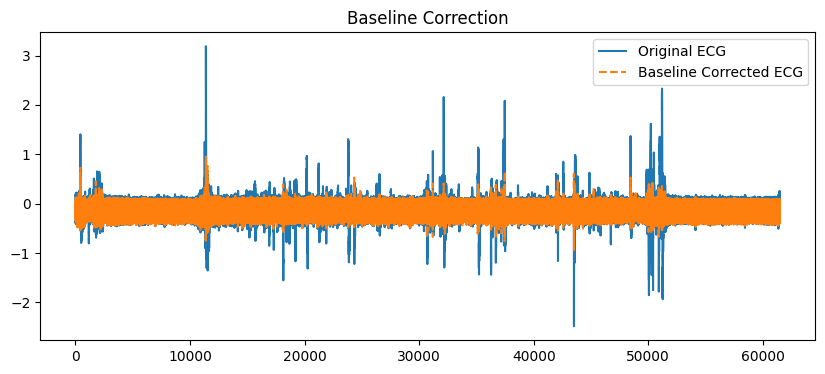

In [8]:
# Preprocessing
# High-pass filter
def butter_highpass(cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def high_pass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# Baseline correction
fs = fields['fs']
cutoff = 0.5
baseline_corrected_signal = high_pass_filter(signal[:, 0], cutoff, fs)

# Original vs baseline corrected ECG plot
plt.figure(figsize=(10, 4))
plt.plot(signal[:, 0], label='Original ECG')
plt.plot(baseline_corrected_signal, label='Baseline Corrected ECG', linestyle='--')
plt.title('Baseline Correction')
plt.legend()
plt.show()

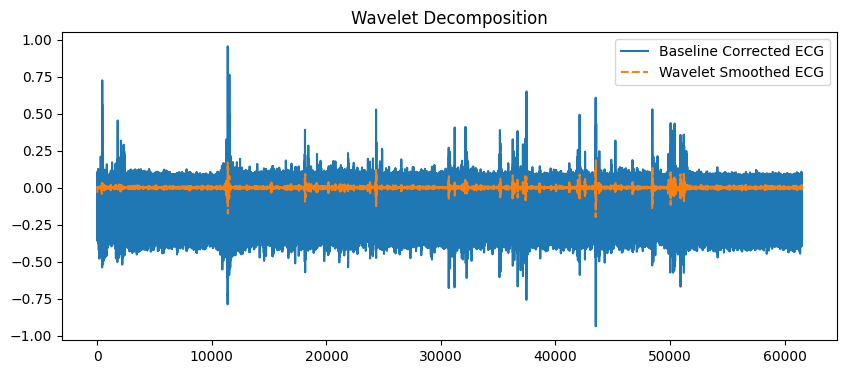

In [10]:
# Wavelet Decomposition using PyWavelets
wavelet = 'db4'
# 4 levels of decomposition
level = 4
coeffs = pywt.wavedec(baseline_corrected_signal, wavelet, level=level)

# Reconstructing the signal from the approximation coefficients to smooth the signal by removing higher frequency noise components
reconstructed_signal = pywt.waverec(coeffs[:1] + [None]*(level), wavelet)

# Original vs wavelet-reconstructed signal plot
plt.figure(figsize=(10, 4))
plt.plot(baseline_corrected_signal, label='Baseline Corrected ECG')
plt.plot(reconstructed_signal, label='Wavelet Smoothed ECG', linestyle='--')
plt.title('Wavelet Decomposition')
plt.legend()
plt.show()

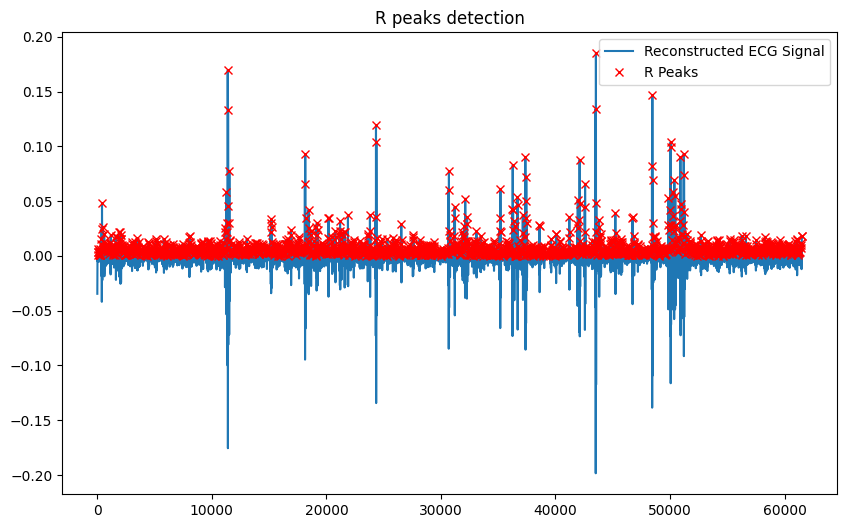

In [11]:
# R-peak detection
r_peaks, _ = find_peaks(reconstructed_signal, height=np.mean(reconstructed_signal), distance=int(fs/2))

# Plot of R-peaks marked on the reconstructed signal
plt.figure(figsize=(10, 6))
plt.plot(reconstructed_signal, label='Reconstructed ECG Signal')
plt.plot(r_peaks, reconstructed_signal[r_peaks], 'rx', label='R Peaks')
plt.title('R peaks detection')
plt.legend()
plt.show()

### Implementation on all dataset

#### Preprocessing

The dataset 'drivedb' used in the research paper does not contain stress labels i.e 'Stressed' or 'Not Stressed', So I've used another research paper 'A Feature Selection Method for Driver Stress Detection Using Heart Rate Variability and Breathing Rate' by Ashkan Parsi, David O'Callaghan, Joseph Lemley, to identify the stress labels.

According to the paper, "As stress can have several sources depending on the mental state of the participants , the hand GSR signal has been used to label the stress in this study. The median GSR values have been used as the cut-off point in previous studies . In this work to train the method on different levels of stress, median ± α has been considered the cut-off point. Therefore, values above the median + α were labelled as stress while the values below the median − α were labelled as no stress. After running an optimization step α = σ⁄ 2 where σ is the standard deviation of the GSR signal."


In some of the samples, hand gsr is not available so I've used foot gsr in those samples. If the mean gsr is between median + α and median - α, then the metric used is the median for stress labels.

In [12]:
# Function to label stress
def label_stress(signal):
  if('hand GSR' in fields['sig_name']):
    gsr_index = fields['sig_name'].index('hand GSR')
  elif('foot GSR' in fields['sig_name']):
    gsr_index = fields['sig_name'].index('foot GSR')

  gsr_signal = signal[:, gsr_index]
  median_gsr = np.median(gsr_signal)
  std_gsr = np.std(gsr_signal)

  # Defining alpha (σ / 2)
  alpha = std_gsr / 2
  # Upper and lower cutoffs
  upper_cutoff = median_gsr + alpha
  lower_cutoff = median_gsr - alpha

  mean_gsr = np.mean(gsr_signal)
  if mean_gsr > upper_cutoff:
      return 'Stressed'
  elif mean_gsr < lower_cutoff:
      return 'Not Stressed'
  else:
      if mean_gsr > median_gsr:
          return 'Stressed'
      else:
          return 'Not Stressed'

Defining all functions

In [17]:
# Function for baseline correction
def butter_highpass(cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def high_pass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def baseline_correction(signal):
    fs = fields['fs']
    cutoff = 0.5
    baseline_corrected_signal = high_pass_filter(signal, cutoff, fs)
    return baseline_corrected_signal

# Function for wavelet decomposition (4 levels)
def wavelet_decomposition(signal):
  wavelet = 'db4'
  level = 4
  coeffs = pywt.wavedec(signal, wavelet, level=level)
  reconstructed_signal = pywt.waverec(coeffs[:1] + [None]*(level), wavelet)
  return reconstructed_signal

# Identifying RR interval
def rr_interval(signal):
  # Peak Detection
  fs = fields['fs']
  r_peaks, _ = find_peaks(reconstructed_signal, height=np.mean(reconstructed_signal), distance=int(fs/2))
  # Calculating RR Intervals
  rr_intervals = np.diff(r_peaks) / fs
  return np.mean(rr_intervals)

# QT interval
def qt_interval(signal):
  # Initialize lists to store indices of Q and T waves
  q_wave_indices = []
  t_wave_indices = []
  fs = fields['fs']
  r_peaks, _ = find_peaks(reconstructed_signal, height=np.mean(reconstructed_signal), distance=int(fs/2))
  for r_peak in r_peaks:
      # Searching for Q wave (local minimum) in the region before the R peak (typically within 10-30 samples before R-peak)
      q_search_region = reconstructed_signal[max(0, r_peak - 30):max(0, r_peak - 10)]
      if len(q_search_region) > 0:
          q_wave_index = np.argmin(q_search_region) + max(0, r_peak - 10)
          q_wave_indices.append(q_wave_index)

      # Search for T wave (local maximum) in the region after the R peak (within 45-55 samples before R-peak)
      t_search_region = reconstructed_signal[min(len(reconstructed_signal), r_peak + 45):min(len(reconstructed_signal), r_peak + 55)]
      if len(t_search_region) > 0:
          t_wave_index = np.argmax(t_search_region) + r_peak
          t_wave_indices.append(t_wave_index)

  # Calculating QT intervals
  qt_intervals = []
  for q_wave, t_wave in zip(q_wave_indices, t_wave_indices):
      if q_wave < t_wave:
          qt_interval = (t_wave - q_wave) / fs # Convert to seconds
          qt_intervals.append(qt_interval)
  return np.mean(qt_intervals)

# EDR interval
def edr_interval(signal):
  fs = fields['fs']
  r_peaks, _ = find_peaks(reconstructed_signal, height=np.mean(reconstructed_signal), distance=int(fs/2))
  # Using the difference in consecutive R-peak amplitudes as a simplified method
  r_peak_amplitudes = reconstructed_signal[r_peaks]
  edr_intervals = np.abs(np.diff(r_peak_amplitudes))
  return np.mean(edr_intervals)

# Extracted features vector
def feature_vector(qt_intervals, rr_intervals, edr_intervals):
  features = np.column_stack((qt_intervals, rr_intervals, edr_intervals))
  return features

# Forming dataset
def form_dataset(features, stress_labels):
    # stress_labels = np.reshape(stress_labels, (-1, 1))
    dataset = np.column_stack((features, stress_labels))
    return dataset

#### Preprocessing and Feature Extraction

In [18]:
# Directory containing all .dat and .hea files
data_dir = '/content/drive/MyDrive/stress-recognition-in-automobile-drivers-1.0.0'

# Initializing lists to store features and labels
qt_intervals = []
rr_intervals = []
edr_intervals = []
stress_labels = []
# Processing each file
for file in os.listdir(data_dir):
    if file.endswith('.dat'):
        record_name = file.split('.')[0]
        record = wfdb.rdsamp(os.path.join(data_dir, record_name))
        signal, fields = record[0], record[1]

        baseline_corrected_signal = baseline_correction(signal[:, 0])
        reconstructed_signal = wavelet_decomposition(baseline_corrected_signal)

        qt = qt_interval(reconstructed_signal)
        rr = rr_interval(reconstructed_signal)
        edr = edr_interval(reconstructed_signal)

        qt_intervals.append(qt)
        rr_intervals.append(rr)
        edr_intervals.append(edr)

        label = label_stress(signal)
        stress_labels.append(label)

features = feature_vector(qt_intervals, rr_intervals, edr_intervals)
stress_labels = np.array(stress_labels)
dataset = form_dataset(features, stress_labels)

In [22]:
df = pd.DataFrame(dataset)
df.columns = ['QT', 'RR', 'EDR', 'Decision']
df.to_csv('dataset.csv', index=False)
print(df)

                      QT                  RR                    EDR  \
0     0.4469283681214421   2.129343930185445   0.005497153678424998   
1    0.38058597218111867  2.2453885018984128   0.002796222930501101   
2   0.045314900153609824  1.3396808378395175   0.008144596000595998   
3     0.6100131752305664  2.3239875389408096  0.0036769125194748863   
4     0.5801627157299182   2.307997219387378    0.00638129472763807   
5     0.5733888410819359   2.455752975677074   0.005101538060106689   
6      0.557280159080866  2.3441334424013944  0.0044660710592284904   
7     0.5313002835031797  2.2764839191860746  0.0036392795429995312   
8       0.52053725175066   2.219313708208473   0.004405620095102461   
9     0.5337039610840861   2.229988594156699  0.0026990996827468074   
10    0.5367062321542345   2.236549261339221   0.003345261416707141   
11    0.5271753362694916   2.221535098442466  0.0021530302948497807   
12    0.3744740532959327   2.164559525531607   0.003866482683338727   
13    

#### Model Training, Testing and Analysis

In [23]:
# Converting to binary labels (encoding 'stressed' as 1 and 'not stressed' as 0)
binary_labels = np.where(stress_labels == 'Stressed', 1, 0)
print(binary_labels)

[0 1 1 1 1 0 0 1 0 0 0 0 0 0 1 1 0 0]


In [24]:
# Since we have only 18 samples in dataset, we use SMOTE to generate synthetic data similar to original data to train our model on
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_synthetic, y_synthetic = smote.fit_resample(features, binary_labels)
print(X_synthetic)
print(y_synthetic)

[[4.46928368e-01 2.12934393e+00 5.49715368e-03]
 [3.80585972e-01 2.24538850e+00 2.79622293e-03]
 [4.53149002e-02 1.33968084e+00 8.14459600e-03]
 [6.10013175e-01 2.32398754e+00 3.67691252e-03]
 [5.80162716e-01 2.30799722e+00 6.38129473e-03]
 [5.73388841e-01 2.45575298e+00 5.10153806e-03]
 [5.57280159e-01 2.34413344e+00 4.46607106e-03]
 [5.31300284e-01 2.27648392e+00 3.63927954e-03]
 [5.20537252e-01 2.21931371e+00 4.40562010e-03]
 [5.33703961e-01 2.22998859e+00 2.69909968e-03]
 [5.36706232e-01 2.23654926e+00 3.34526142e-03]
 [5.27175336e-01 2.22153510e+00 2.15303029e-03]
 [3.74474053e-01 2.16455953e+00 3.86648268e-03]
 [6.00819586e-01 2.36898396e+00 3.47554526e-03]
 [5.38610422e-01 2.26761781e+00 2.09584935e-03]
 [5.36945339e-01 2.30735362e+00 2.73818594e-03]
 [3.74474053e-01 2.16455953e+00 3.86648268e-03]
 [3.25940860e-01 2.14165883e+00 4.12538832e-03]
 [5.49750582e-01 2.27641253e+00 2.34252468e-03]
 [5.74223789e-01 2.31172652e+00 3.53952977e-03]
 [7.35426867e-02 1.39409374e+00 7.882910

In [26]:
# Normalizing (scaling) features using StandardScaler, fit, transform
X = StandardScaler().fit(features).transform(features)
X_synthetic = StandardScaler().fit(X_synthetic).transform(X_synthetic)

#### Model 1 : Cubic SVM with Gaussian

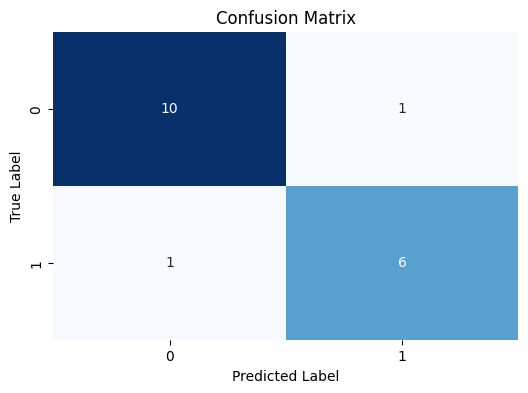

              precision    recall  f1-score   support

           0       0.91      0.91      0.91        11
           1       0.86      0.86      0.86         7

    accuracy                           0.89        18
   macro avg       0.88      0.88      0.88        18
weighted avg       0.89      0.89      0.89        18

Accuracy of Cubic SVM with Gaussian model: 88.89%


In [30]:
svc_model = SVC(kernel ='poly', degree=3, C=100)
svc_model.fit(X_synthetic, y_synthetic)
# Making predictions (testing on original data)
y_pred = svc_model.predict(X)
# Plotting confusion matrix
# 0 represents 'Not Stressed' and 1 represents 'Stressed'
cm1 = confusion_matrix(binary_labels, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()
print(classification_report(binary_labels, y_pred))
# Calculating accuracy
accuracy = accuracy_score(binary_labels, y_pred)
print(f'Accuracy of Cubic SVM with Gaussian model: {accuracy * 100:.2f}%')

#### Model 2 : Tree Optimised SVM

This model is a combination of Decision Tree and SVM algorithms. So, we use Voting Classifier to combine both models.

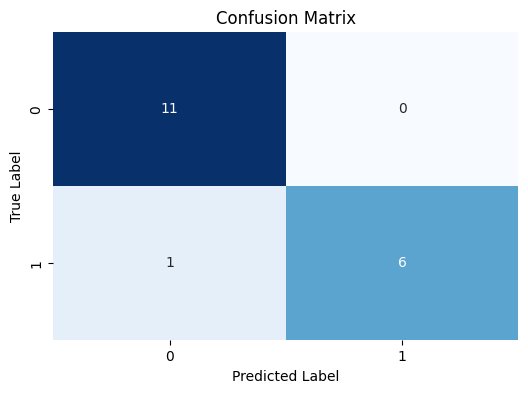

              precision    recall  f1-score   support

           0       0.92      1.00      0.96        11
           1       1.00      0.86      0.92         7

    accuracy                           0.94        18
   macro avg       0.96      0.93      0.94        18
weighted avg       0.95      0.94      0.94        18

Accuracy of Tree Optimised SVM model: 94.44%


In [34]:
dec_tree = DecisionTreeClassifier(criterion="entropy", max_depth = 12)
svc_model = SVC(kernel='poly', degree=1, C=100, probability=True)
voting_model = VotingClassifier(estimators=[
    ('svc', svc_model),
    ('tree', dec_tree)
], voting='soft')  # Probability-based voting
voting_model.fit(X_synthetic, y_synthetic)
# Making predictions on test set
y_pred_combined = voting_model.predict(X)
cm2 = confusion_matrix(binary_labels, y_pred_combined)
plt.figure(figsize=(6, 4))
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()
print(classification_report(binary_labels, y_pred_combined))
# Calculating accuracy
accuracy = accuracy_score(binary_labels, y_pred_combined)
print(f'Accuracy of Tree Optimised SVM model: {accuracy * 100:.2f}%')

Thus, we can see that accuracy increases by using a Tree Optimized SVM.

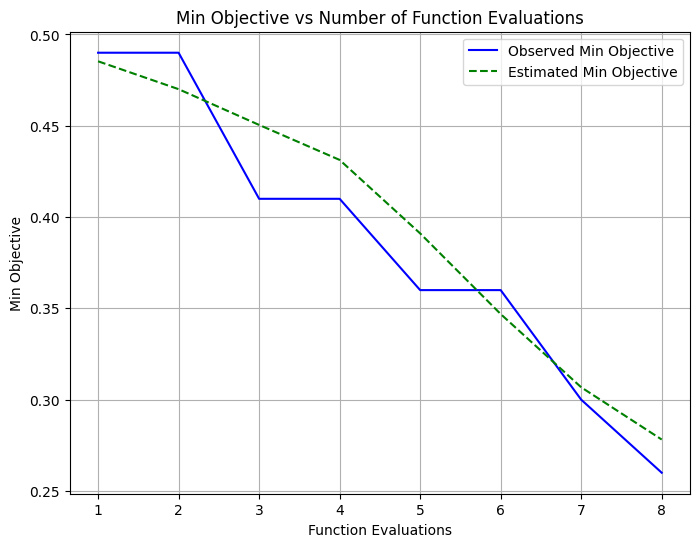

In [39]:
# Plot of Minimum Objective versus Number of function Evaluations for Cubic SVM
svc_model = SVC(kernel='poly', degree=3)
# Defining hyperparameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto']
}
# Custom scorer: minimize the error (1 - accuracy)
scorer = make_scorer(accuracy_score)
# Initializing Grid Search
grid_search = GridSearchCV(svc_model, param_grid, scoring=scorer, cv=5, return_train_score=False)
grid_search.fit(X_synthetic, y_synthetic)
results = grid_search.cv_results_
# Extract objective function (error = 1 - accuracy)
errors = 1 - results['mean_test_score']
# Number of evaluations
num_evals = np.arange(1, len(errors) + 1)
# Minimum objective value up to each evaluation
min_objective = np.minimum.accumulate(errors)
# Estimated minimum objective using a gaussian smoothing function
estimated_min_objective = gaussian_filter1d(errors, sigma=1)
estimated_min_objective = np.minimum.accumulate(estimated_min_objective)

plt.figure(figsize=(8, 6))
plt.plot(num_evals, min_objective, label='Observed Min Objective', color='blue')
plt.plot(num_evals, estimated_min_objective, label='Estimated Min Objective', color='green', linestyle='--')
plt.xlabel('Function Evaluations')
plt.ylabel('Min Objective')
plt.title('Min Objective vs Number of Function Evaluations')
plt.grid(True)
plt.legend()
plt.show()

As objective value become less, it denotes a better optimised SVM model.